Generates plots of trends in SLP for the Arctic

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os, glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Functions to calculate trends

In [3]:
def _predict(t, slope, intercept):
    
    x = xr.DataArray(t.to_pandas().index.to_julian_date().values, coords=[t], dims=['time'])
    return x*slope + intercept
    
def _linear_trend(x):
    
    import scipy.stats
    
    nt = x.shape[0]
    
    t = x.time.to_pandas().index.to_julian_date().values
    tanom = xr.DataArray(t - t.mean(), coords=[x.time], dims=['time'])
    
    xanom = x - x.mean(dim='time')
    
    tvar = (tanom*tanom).sum(dim='time')/ (nt-1)  #xss
    xvar = (xanom**2).sum(dim='time') / (nt-1) #yss
    covar = (tanom * xanom).sum(dim='time') / (nt-1) #xys
    
    slope = covar / tvar
    intercept = x.mean(dim='time') - t.mean()*slope
    
    df = nt-2
    r = covar / (tvar * xvar)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    #print (t.load().min(), t.load().max())
    p = xr.apply_ufunc(scipy.stats.t.sf, abs(t), df, dask='allowed')
    
    slope = slope*365.4
    slope.attrs['units'] = 'hPa/year'
    
    intercept.attrs['units'] = 'hPa'
    
    ds = xr.Dataset({'slope': slope,
                     'intercept': intercept,
                     'p': p})
    return ds

## Get data

In [22]:
data_dir = '/disks/arctic5_raid/abarrett/MERRA2/monthly/SLP'
fileList = glob.glob(os.path.join(data_dir, 'MERRA2_???.tavgM_2d_slv_Nx.SLP.??????.nc4'))
ds = xr.open_mfdataset(fileList, concat_dim='time')
ds['SLP'] = ds['SLP']*1e-2  # convert to hPa
ds['SLP'].attrs['units'] = 'hPa'

print (ds['time'][-1])
ybeg = 1979
yend = 2017

ds = ds.sel(time=slice('{:d}-01-01'.format(ybeg),'{:d}-12-31'.format(yend)))
ds.time

<xarray.DataArray 'time' ()>
array('2017-07-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-07-01T00:30:00
Attributes:
    standard_name:  time
    long_name:      time


<xarray.DataArray 'time' (time: 451)>
array(['1980-01-01T00:30:00.000000000', '1980-02-01T00:30:00.000000000',
       '1980-03-01T00:30:00.000000000', ..., '2017-05-01T00:30:00.000000000',
       '2017-06-01T00:30:00.000000000', '2017-07-01T00:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T00:30:00 1980-02-01T00:30:00 ...
Attributes:
    standard_name:  time
    long_name:      time

## Calculate seasonal means

In [5]:
r = ds['SLP'].rolling(time=3, center=True)
season = r.construct('window_dim', stride=3).mean(dim='window_dim')
season.time[-1]

<xarray.DataArray 'time' ()>
array('2017-07-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-07-01T00:30:00
Attributes:
    standard_name:  time
    long_name:      time

## Calculate trends in seasonal means

In [6]:
trend = season.groupby('time.season').apply(_linear_trend)
trend

<xarray.Dataset>
Dimensions:    (lat: 361, lon: 576, season: 4)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 -87.5 -87.0 -86.5 ...
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 -177.5 -176.9 ...
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    slope      (season, lat, lon) float64 dask.array<shape=(4, 361, 576), chunksize=(1, 361, 576)>
    intercept  (season, lat, lon) float64 dask.array<shape=(4, 361, 576), chunksize=(1, 361, 576)>
    p          (season, lat, lon) float64 0.07158 0.07158 0.07158 0.07158 ...

## Plot trends

### Get Greenland geometry

In [8]:
from cartopy.io.shapereader import natural_earth, Reader
from cartopy.mpl.patch import geos_to_path

shape_records = Reader(natural_earth(resolution='110m',
                                         category='cultural',
                                         name='admin_0_countries')).records()

for country in shape_records:
    if country.attributes['NAME_LONG'] == 'Greenland':
        greenland_geom = country.geometry
        break
        


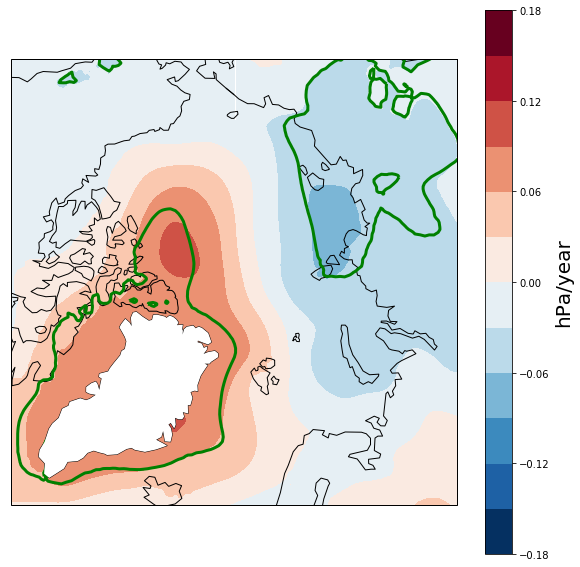

In [29]:
from cartopy.io.shapereader import natural_earth, Reader
from cartopy.mpl.patch import geos_to_path
from mpl_toolkits.axes_grid1 import make_axes_locatable

map_proj = ccrs.NorthPolarStereo()
levels = np.linspace(-0.18,0.18,13)

fig = plt.figure(figsize=(10,10))

ax = plt.subplot(projection=map_proj)

im = trend['slope'].sel(season='JJA').plot.contourf(ax=ax, levels=levels, transform=ccrs.PlateCarree())
im.colorbar.set_label('hPa/year', fontsize=20)

# Transform coordinates for significance contours to projected coords for
# better plotting
lon2d, lat2d = np.meshgrid(trend['lon'].data, trend['lat'].data)
coords = map_proj.transform_points(ccrs.PlateCarree(), lon2d, lat2d)

ax.contour(coords[:,:,0], coords[:,:,1], trend['p'].sel(season='JJA'), levels=[0.05], 
               colors='g', linewidths=3)

ax.coastlines()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
# Without this aspect attributes the maps will look chaotic and the
# "extent" attribute above will be ignored
ax.set_aspect('equal', 'box-forced')
ax.set_title('', fontsize=15)

ax.add_geometries(greenland_geom, ccrs.PlateCarree(),
                  edgecolor=None, facecolor='white', alpha=1., zorder=4)

fig.savefig('slp_trend_1980to2017.png')    